In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import eli5
import shap
from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
main_path = r'd:\Documents\Private\Kaggle\IEEEFraud'

In [3]:
import sys
sys.path.append(main_path)
from BayDS import *

In [4]:
experiment_name = '31.08'
main_learning_folder = main_path+'/Snapshots/'+experiment_name


In [5]:
train = pd.read_pickle(f'{main_learning_folder}/train.pkl')
test = pd.read_pickle(f'{main_learning_folder}/test.pkl')


In [7]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT'], axis=1)
y = train.sort_values('TransactionDT')['isFraud'].astype(np.uint8)
test = test.sort_values('TransactionDT').drop(['TransactionDT'], axis=1)

X.drop('Date', axis=1, inplace=True)
X=X.astype(np.float32)
test.drop('Date', axis=1, inplace=True)
test=test.astype(np.float32)
del train
gc.collect()

0

In [8]:
# Setting model_folder
model_name = 'lightgbm-test'
model_folder = f'{main_learning_folder}/{model_name}'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

In [9]:
n_fold = 5
# folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=n_fold)
# folds = GroupKFold(n_splits=5)
# groups = pd.read_pickle('./groups.pkl').values

In [26]:
space_lgb = {
    'num_leaves': np.arange(10, 100, 30),
    'min_child_weight': np.arange(1, 300, 80),
    'learning_rate': 0.01,
    'max_bin': np.arange(9, 40, 1),
    'lambda_l1': np.arange(0, 3, 1), 
    'lambda_l2': np.arange(0, 3, 1),
    'min_data_in_leaf' : np.arange(5, 250, 90),
    'min_sum_hessian_in_leaf' : np.arange(0.0001, 0.01, 0.005),
    'bagging_fraction' : np.arange(0, 0.9, 0.3),
    'max_bin': np.arange(10, 30, 10),
    'feature_fraction' : np.arange(0.1, 0.9, 0.3),
    'bagging_freq' : np.arange(200, 1000, 400),
    'min_gain_to_split': np.arange(0.1, 1, 0.3),     
}

In [10]:
params = {'num_leaves': 10,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
#           'device': 'gpu'
         }
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 50,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold
    
}

In [11]:
with open(f'{model_folder}/training_params.json', 'w') as f:
    q = json.dumps(train_options,indent=2)
    f.write(q)

Fold 1 started at Sat Aug 31 17:19:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.873613	training's auc: 0.873622	valid_1's auc: 0.836261	valid_1's auc: 0.836255
Fold 2 started at Sat Aug 31 17:20:23 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.87295	training's auc: 0.87286	valid_1's auc: 0.871624	valid_1's auc: 0.871857
Fold 3 started at Sat Aug 31 17:21:10 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.874687	training's auc: 0.87462	valid_1's auc: 0.862634	valid_1's auc: 0.862559
Fold 4 started at Sat Aug 31 17:21:55 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.869721	training's auc: 0.869642	valid_1's auc: 0.8755	v

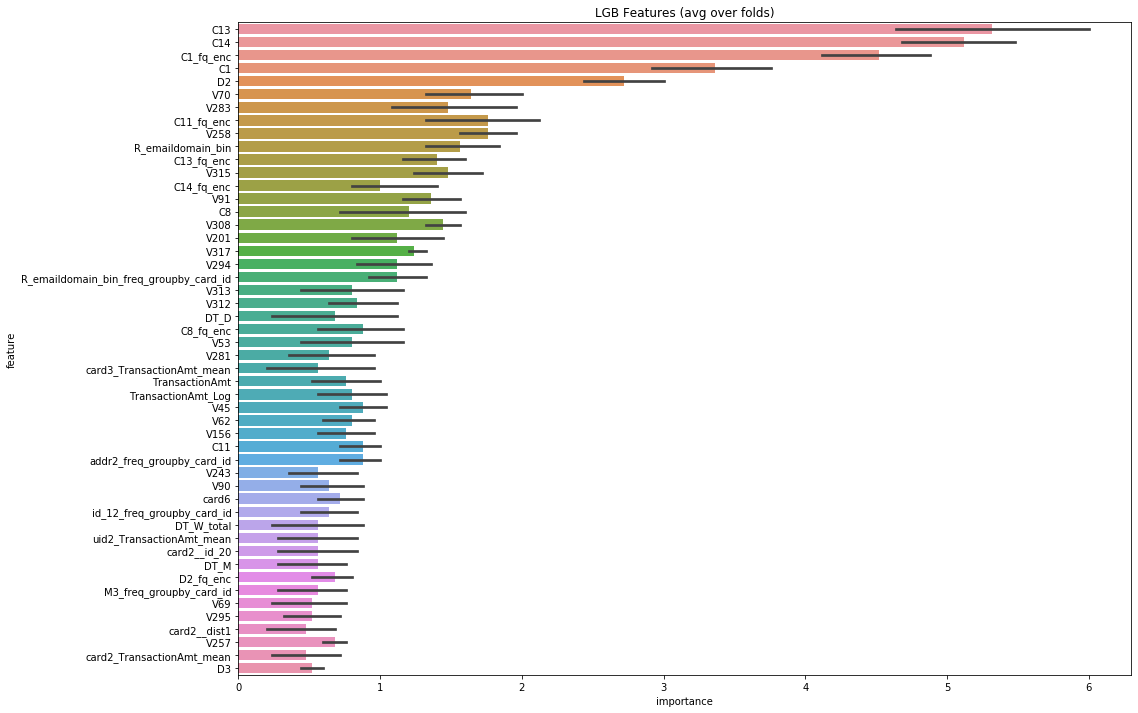

In [12]:
result_dict_lgb = train_model_classification(X=X, X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

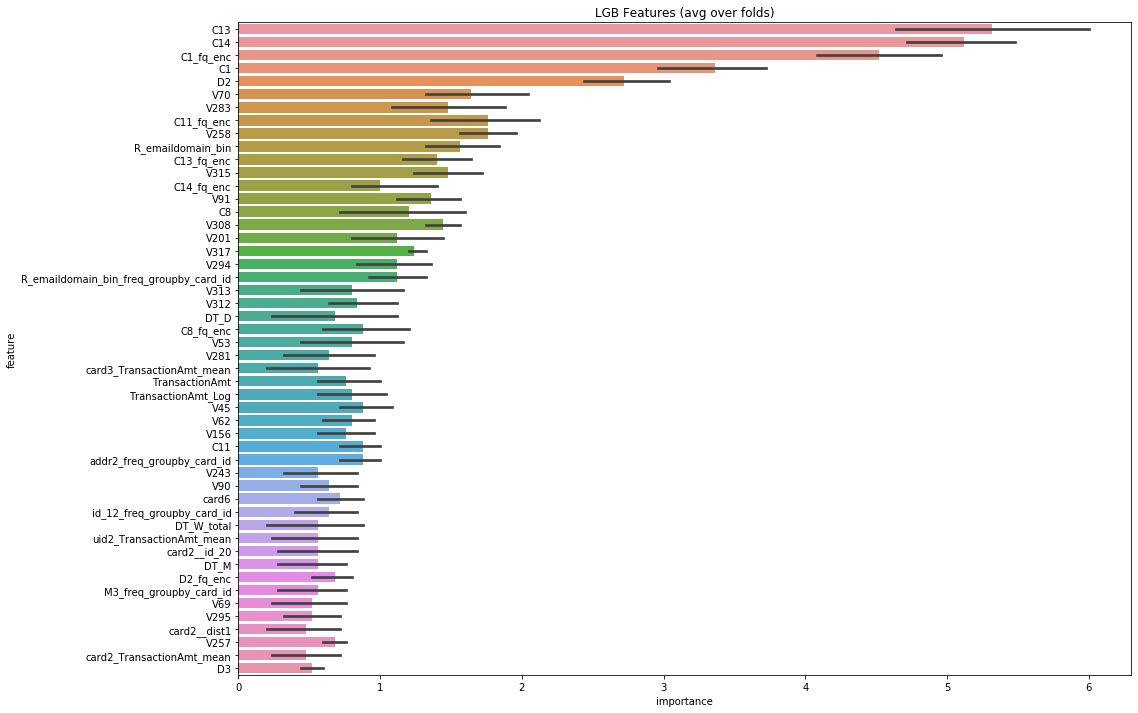

In [13]:
# plt.savefig(f'{learning_folder}/feature_importance.png')
from lib.training import plot_importance
plot_importance(result_dict_lgb,f'{model_folder}/feature_importance.png')

In [14]:
import pickle
with open(f'{model_folder}/results_dict.pkl', 'wb') as f:
#     q = json.dumps(result_dict_lgb,indent=2)
    pickle.dump(result_dict_lgb,f)
#     f.write(q)